In [1]:
import kagglehub
from torch.utils.data import DataLoader
import torch
from torchvision.datasets import ImageFolder
from torchvision import transforms
import matplotlib.pyplot as plt
import einops


In [2]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop((288,288), scale=(0.2, 1.0), interpolation=3),  # 3 is bicubic
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
# Download latest version
path = kagglehub.dataset_download("arjunashok33/miniimagenet")
dataset = ImageFolder(path, transform=train_transform)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


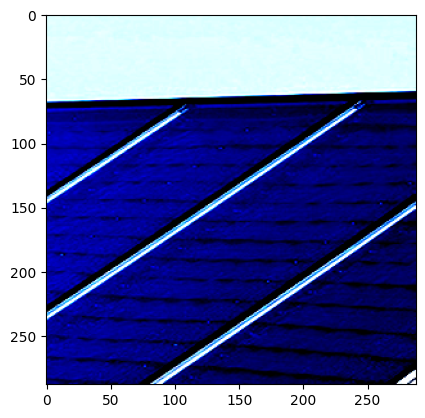

In [3]:
batch = next(iter(dataloader))
plt.imshow(batch[0][0].permute(1, 2, 0).numpy())

In [9]:
from mae import BaseImageTokenizer, FoveatedImageTokenizer, MAE_Encoder, MAE_Decoder, MAE_ViT

tokenizer = BaseImageTokenizer()
encoder = MAE_Encoder(
    num_tokens=tokenizer.get_num_tokens(),
    num_registers=1,
    patch_size=tokenizer.get_token_size(),
    depth=12,
    embedding_dim=768,
    num_heads=12,
    act_layer="gelu",
)
decoder = MAE_Decoder(
    num_tokens=tokenizer.get_num_tokens(),
    num_registers=1,
    patch_size=tokenizer.get_token_size(),
    depth=8,
    embedding_dim=384,
    num_heads=12,
)
mae = MAE_ViT(
    tokenizer=tokenizer,
    encoder=encoder,
    decoder=decoder,
)

img = batch[0]
centers = (torch.rand((img.size(0), 2), dtype=torch.float32, device=img.device) * 2 - 1) * 0.5
tokens, pred_tokens, mask = mae(img, centers)

loss = torch.mean((pred_tokens - tokens) ** 2 * mask / 0.75)
print(loss)


tensor(2.0060, grad_fn=<MeanBackward0>)


torch.Size([324, 2, 768])


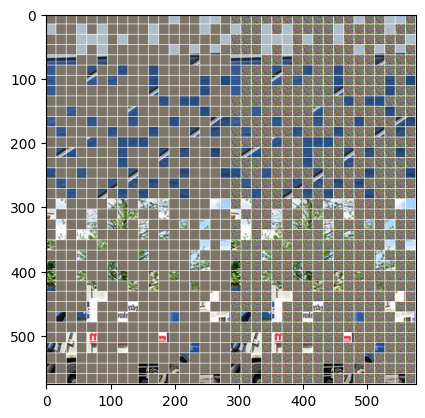

In [ ]:
denormalize = transforms.Normalize(
    mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
    std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
)

print(tokens.shape)

viz = []
mask = mask.to(torch.bool)
viz_tokens = denormalize(einops.rearrange(tokens, "n b (c h w) -> b n c h w", c=3, h=16, w=16)).clip(0, 1)
viz_tokens_masked = denormalize(einops.rearrange(tokens * (~mask), "n b (c h w) -> b n c h w", c=3, h=16, w=16)).clip(0, 1)
viz_pred_tokens = pred_tokens.detach()
viz_pred_tokens[~mask] = tokens[~mask]  # Fill masked tokens with original tokens
viz_pred_tokens = denormalize(einops.rearrange(viz_pred_tokens, "n b (c h w) -> b n c h w", c=3, h=16, w=16)).clip(0, 1)
for i in range(viz_tokens.size(0)):
    viz.append(
        torch.cat([
            tokenizer.generate_visualization(viz_tokens[i]), 
            tokenizer.generate_visualization(viz_tokens_masked[i]),
            tokenizer.generate_visualization(viz_pred_tokens[i])
        ], dim=2)
    )
viz = torch.cat(viz, dim=1)
plt.imshow(viz.permute(1, 2, 0).numpy())

In [6]:
from gaze_av_aloha.policies.gaze_policy.vit import create_vit_b

vit = create_vit_b(tokenizer.get_num_tokens(), tokenizer.get_token_size())
vit.eval()


def copy_matching_weights(src_module, tgt_module, startswith=()):
    src_state = dict(src_module.named_parameters())
    tgt_state = dict(tgt_module.named_parameters())

    for name, param in tgt_state.items():
        if any(name.startswith(prefix) for prefix in startswith):
            if name in src_state and src_state[name].shape == param.shape:
                param.data.copy_(src_state[name].data)

copy_matching_weights(encoder, vit, startswith=["patch_emb", "pos_enc", "reg_tokens", "blocks"])


In [7]:
class DummyPatchShuffle():
    def forward(self, patches : torch.Tensor, masks : torch.Tensor = None):
        return patches, masks, None, None

x = torch.randn(32, tokenizer.get_num_tokens(), tokenizer.get_token_size() ** 2 * 3, device=img.device)
mask = torch.ones((32, tokenizer.get_num_tokens()), dtype=torch.bool, device=img.device)

encoder.shuffle = DummyPatchShuffle()
encoder.norm = torch.nn.Identity()

encoder_feat, _ = encoder(x, mask)
encoder_feat = encoder_feat.transpose(0, 1)  # (B, S, D)
encoder_feat, encoder_reg = encoder_feat[:, encoder.num_registers:], encoder_feat[:, :encoder.num_registers]
vit_feat, vit_reg = vit(x, mask)

print(encoder_feat.shape, vit_feat.shape)

print(encoder_feat[0,0,:10])
print(vit_feat[0,0,:10])

print()

print(encoder_reg[0,0,:10])
print(vit_reg[0,0,:10])

torch.Size([32, 20, 768]) torch.Size([32, 20, 768])
tensor([ 1.7976,  3.5731, -1.3721, -0.5574, -1.0049,  0.0293,  0.9252,  0.3123,
        -0.5121,  1.4579], grad_fn=<SliceBackward0>)
tensor([ 1.7976,  3.5731, -1.3721, -0.5574, -1.0049,  0.0293,  0.9252,  0.3123,
        -0.5121,  1.4579], grad_fn=<SliceBackward0>)

tensor([-0.2385,  3.6125, -1.9469,  0.9282, -1.0486,  1.3569, -1.5488, -1.3524,
         0.6717,  0.5058], grad_fn=<SliceBackward0>)
tensor([-0.2385,  3.6125, -1.9469,  0.9282, -1.0486,  1.3569, -1.5488, -1.3524,
         0.6717,  0.5058], grad_fn=<SliceBackward0>)


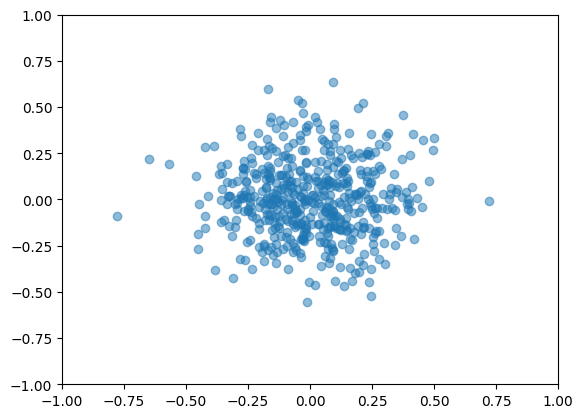

In [8]:
# plot torch.randn(500, 2) * 0.2
x = torch.randn(500, 2) * 0.2
# x = (torch.rand((500, 2)) * 2 - 1) * 0.5
plt.scatter(x[:, 0].numpy(), x[:, 1].numpy(), alpha=0.5)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.show()